<a href="https://colab.research.google.com/github/dwsds/Chemical-Compound-Classification/blob/main/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw,AllChem
import torch
from torch_geometric.nn import models
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Converting the data from SMILES to atomic coordinates

In [ ]:
df=pd.read_csv('training_data_bitter.csv')
df['IsValid']=0

for i in range(df.shape[0]):
    m=Chem.MolFromSmiles(df.loc[i,'SMILES'])
    try:
        if(m.GetNumAtoms()):
            df.loc[i,'IsValid']=1

            continue
        else:
            print(False)
    except:
        print(False)

df1=df[df['IsValid']==1].drop(columns=['IsValid'])

atomicNums=[]
pos=[]
Y0=[]
for i,y in zip(df1['SMILES'],df1['Label']):
    try:
        m=Chem.MolFromSmiles(i)
        m = Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m)
        j=0
        temp_pos=[]
        temp_atomicNums=[]
        for k in m.GetAtoms():
            temp_atomicNums.append(k.GetAtomicNum())
            temp_pos.append([m.GetConformer().GetAtomPosition(j).x,m.GetConformer().GetAtomPosition(j).y,m.GetConformer().GetAtomPosition(j).z])
            j+=1
        atomicNums.append(temp_atomicNums)
        pos.append(temp_pos)
        Y0.append(y)
    except:
        print("invalid")

Y=torch.tensor(Y0)
atomic_nums_tensor=[torch.tensor(i,dtype=torch.int64) for i in atomicNums]
pos_tensor=[torch.tensor(i) for i in pos]

## Running the Model

In [ ]:
total_epochs=0
cost = []
model=models.SchNet(readout='mean')
# model=model.to(device)

def criterion(y_pred, y):
    out = torch.mean((y-y_pred)**2)
    return out
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
total=0

In [ ]:
epochs=50

In [ ]:
for epoch in range(epochs):
    total=0
    epoch = epoch + 1
    for at,ps, y in zip(atomic_nums_tensor,pos_tensor, Y):
        yhat = model(at,ps)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total+=loss.item()
    cost.append(total)
    total_epochs+=1
    if epoch % 1 == 0:
        print(f"epochs : {total_epochs} total : {total}")

epochs : 1 total : 599.405688346674
epochs : 2 total : 354.06847232818257
epochs : 3 total : 305.7639268277178
epochs : 4 total : 293.16857902721244
epochs : 5 total : 288.58278160142413
epochs : 6 total : 285.57394388754386
epochs : 7 total : 282.998463413194
epochs : 8 total : 280.6690099692446
epochs : 9 total : 278.5443461324329
epochs : 10 total : 276.59935268553284
epochs : 11 total : 274.8102965860021
epochs : 12 total : 273.155161061495
epochs : 13 total : 271.6159735050038
epochs : 14 total : 270.1774311843742
epochs : 15 total : 268.8271122385021
epochs : 16 total : 267.5546338196773
epochs : 17 total : 266.3512222791795
epochs : 18 total : 265.2092621365047
epochs : 19 total : 264.1224851070685
epochs : 20 total : 263.0859207410187
epochs : 21 total : 262.09458604120795
epochs : 22 total : 261.14443366360035
epochs : 23 total : 260.2317869511165
epochs : 24 total : 259.3530113024131
epochs : 25 total : 258.5054319940839
epochs : 26 total : 257.6864285333527
epochs : 27 total

## Loss function vs no. of iterations

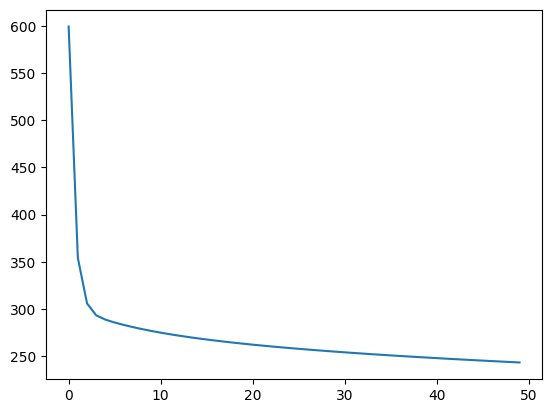

In [ ]:
plt.plot(np.arange(len(cost)),cost)
plt.show()

In [ ]:
pred_vals=[model(atomic_nums_tensor[i],pos_tensor[i]).detach().numpy()[0][0] for i in range(len(Y))]

In [ ]:
def accuracy(x,y,n):
    sum=0
    for i in range(n):
        if(x[i]==y[i]):
            sum+=1
    return sum/n

pred_classifications=[1 if pred_vals[i]>=0.5 else 0 for i in range(len(pred_vals))]
print(accuracy(pred_classifications,Y,len(Y)))
plt.scatter(range(len(pred_vals[:100])),Y[:100],color='blue')
plt.scatter(range(len(pred_vals[:100])),pred_classifications[:100],color='orange')
plt.show()

## Checking accuracy for testing data

In [ ]:
df_test=pd.read_csv('testing_data_bitter.csv')
df_test['IsValid']=0

for i in range(df_test.shape[0]):
    m=Chem.MolFromSmiles(df_test.loc[i,'SMILES'])
    try:
        if(m.GetNumAtoms()):
            df_test.loc[i,'IsValid']=1

            continue
        else:
            print(False)
    except:
        print(False)

df1_test=df_test[df_test['IsValid']==1].drop(columns=['IsValid'])

atomicNums_test=[]
pos_test=[]
Y0_test=[]
for i,y in zip(df1_test['SMILES'],df1_test['Label']):
    try:
        m=Chem.MolFromSmiles(i)
        m = Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m)
        j=0
        temp_pos=[]
        temp_atomicNums=[]
        for k in m.GetAtoms():
            temp_atomicNums.append(k.GetAtomicNum())
            temp_pos.append([m.GetConformer().GetAtomPosition(j).x,m.GetConformer().GetAtomPosition(j).y,m.GetConformer().GetAtomPosition(j).z])
            j+=1
        atomicNums_test.append(temp_atomicNums)
        pos_test.append(temp_pos)
        Y0_test.append(y)
    except:
        print("invalid")

Y_test=torch.tensor(Y0_test)
atomic_nums_tensor_test=[torch.tensor(i,dtype=torch.int64) for i in atomicNums_test]
pos_tensor_test=[torch.tensor(i) for i in pos_test]

In [ ]:
pred_vals_test=[model(atomic_nums_tensor_test[i],pos_tensor_test[i]).detach().numpy()[0][0] for i in range(len(Y_test))]

In [ ]:
pred_classifications_test=[1 if pred_vals_test[i]>=0.5 else 0 for i in range(len(pred_vals_test))]
print(f"accuracy : {accuracy(pred_classifications_test,Y_test,len(Y_test))}")

accuracy : 0.6923076923076923


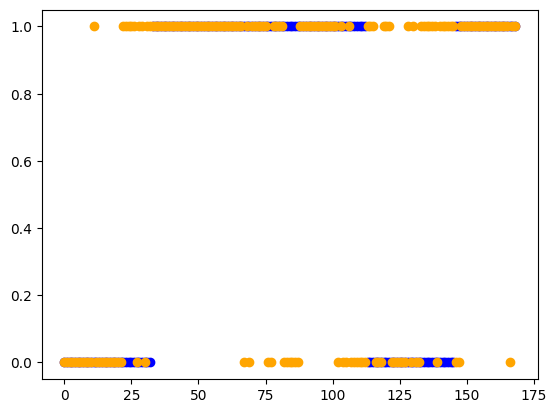

In [ ]:
plt.scatter(range(len(pred_vals_test)),Y_test,color='blue')
plt.scatter(range(len(pred_vals_test)),pred_classifications_test,color='orange')
plt.show()

## Citations
- [SchNet A deep learning architecture for molecules and materialss]( https://www.researchgate.net/publication/324101624_SchNet_-_A_deep_learning_architecture_for_molecules_and_materia)
- [SchNet A continuous-filter convolutional neuralnetwork for modeling quantum interactions](https://arxiv.org/pdf/1706.08566.pdf)8566.pdf